![alt text](https://www.mathworks.com/content/mathworks/www/en/discovery/convolutional-neural-network/jcr:content/mainParsys/image_copy.adapt.full.high.jpg/1497876372993.jpg)

![alt text](https://leonardoaraujosantos.gitbooks.io/artificial-inteligence/content/more_images/Convolution_schematic.gif) 

## Lets apply this to peak sequence from transcription factors WRKY45 and WRKY18

The expected motifs have been indiependently verified. See the [DAP-seq website](http://neomorph.salk.edu/dap_web/pages/browse_table_aj.php) and also Figure 1 from [this paper](https://www.pnas.org/content/111/6/2367)

#### The WRKY45 motif (from DAP-seq site) and it's reverse complement

![WRKY45 motif](http://neomorph.salk.edu/dap_web/pages/dap_data_v4/motifs/WRKY_tnt/WRKY45_col_a/meme_out/logo1.png)![WRKY45 motif](http://neomorph.salk.edu/dap_web/pages/dap_data_v4/motifs/WRKY_tnt/WRKY45_col_a/meme_out/logo_rc1.png)

#### The WRKY18 motif (from DAP-seq site) and it's reverse complement


![WRKY45 motif](http://neomorph.salk.edu/dap_web/pages/dap_data_v4/motifs/WRKY_tnt/WRKY18_col_a/meme_out/logo_rc1.png)![WRKY45 motif](http://neomorph.salk.edu/dap_web/pages/dap_data_v4/motifs/WRKY_tnt/WRKY18_col_a/meme_out/logo1.png)

#### The WRKY45 motifs (from [https://www.pnas.org/content/111/6/2367])
![WRKY45 motif](wrky_motifs.png)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import os
customdata="/global/projectb/scratch/mmingay/dap_learning/training/"
files=os.listdir(customdata)
files

['WRKY18_200bp_top1000_peakseqs_labels.txt',
 'WRKY45_50bp_top1000_peakseqs_labels.txt',
 'WRKY18_50bp_top1000_peakseqs_labels.txt',
 'WRKY45_200bp_top1000_peakseqs_labels.txt',
 'WRKY45_100bp_top1000_peakseqs_labels.txt',
 'WRKY18_50bp_all_peakseqs_labels.txt',
 'WRKY45_50bp_all_peakseqs_labels.txt',
 'WRKY18_100bp_top1000_peakseqs_labels.txt']

##### We will use the file: `WRKY18_50bp_top1000_peakseqs_labels.txt`

In [2]:
datafile = customdata + files[2]
datafile

'/global/projectb/scratch/mmingay/dap_learning/training/WRKY18_50bp_top1000_peakseqs_labels.txt'

In [33]:
import warnings; warnings.simplefilter('ignore')
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import pandas as pd
import numpy as np
df=pd.read_csv(datafile, sep="\t", header=None, names=['id', 'sequence', 'label'])
df.head()

# get labels in one_hot_encoded format
labels = list(str(string) for string in df.label)
one_hot_encoder = OneHotEncoder(n_values=2)
labels = np.array(labels).reshape(-1, 1)
input_labels = one_hot_encoder.fit_transform(labels).toarray()

#get sequences and one hot encode them
sequences = list(str(string) for string in df.sequence)

# The LabelEncoder encodes a sequence of bases as a sequence of integers.
integer_encoder = LabelEncoder()  
# The OneHotEncoder converts an array of integers to a sparse matrix where 
# each row corresponds to one possible value of each feature.
one_hot_encoder = OneHotEncoder(n_values=4)   
input_features = []  

for sequence in sequences:
    try:
        integer_encoded = integer_encoder.fit_transform(list(sequence))
        integer_encoded = np.array(integer_encoded).reshape(-1, 1)
        one_hot_encoded = one_hot_encoder.fit_transform(integer_encoded)
        input_features.append(one_hot_encoded.toarray())
    except ValueError:
            print(sequence)
            continue 
np.set_printoptions(threshold=40)
input_features = np.stack(input_features)

print("shape of our input feature array: ", input_features[0].shape)
print("shape of our input feature array: ", np.array(input_features[0]).shape)
print("number of sequences: " + str(len(sequences)))
print("length of individual sequence: " + str(len(sequences[100])))
print("number of labels: ", len(df.label))

#Now seperate training (0.75) and testing (0.25) data
from sklearn.model_selection import train_test_split

train_features, test_features, train_labels, test_labels = train_test_split(
    input_features, input_labels, test_size=0.25, random_state=42)

print("shape of training features:", train_features.shape)

shape of our input feature array:  (50, 4)
shape of our input feature array:  (50, 4)
number of sequences: 1996
length of individual sequence: 50
number of labels:  1996
shape of training features: (1497, 50, 4)


## Now we will create a Convolutional Neural Network architecture with the following layers:

1. *Conv1D*: This is our 1-dimensional convolutional layer. It scans our input using a defined window (kernel size) and extracts abstract features from the input (1 feature per filter). We will set it to have a kernel size of 12 (12 base scanning window) and 32 filters (or features).

2. *MaxPooling1D*: This is our pooling function which allows for **non-linear downsampling** of our features. Since the pool size is 4 This is useful for creating a more robust model that is less sensitive to absolute positioning. It pools similar features/filters and extracts the most useful ones.

3. *Flatten*: This layer flattens the output of the *MaxPooling1D* into a single array combining the results of the convolution and pooling layers across all 32 filters.

4. *Dense (16)*: This first Dense tensor creates a layer that compresses the representation of the flattened layer, resulting in smaller layer with 16 tensors.

5. *Dense (2)*: This layer converges the 16 tensors from the previous layer into the output layer that consists of the two possible response values (0 or 1).

In [34]:
import warnings; warnings.simplefilter('ignore')
from tensorflow.keras.layers import Conv1D, Dense, MaxPooling1D, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.backend import clear_session

model = Sequential()
model.add(Conv1D(filters=32, kernel_size=12, 
                 input_shape=(train_features.shape[1], 4)))

# Could modify the pool size....how many subsequent bases usually seen in motif?
# Why aren't we using stride with stride = 1?

#model.add(MaxPooling1D(pool_size=4))
model.add(MaxPooling1D(pool_size=6, strides=2))
model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dense(2, activation='softmax'))

model.compile(loss='binary_crossentropy', optimizer='adam', 
              metrics=['binary_accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, 39, 32)            1568      
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 17, 32)            0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 544)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 16)                8720      
_________________________________________________________________
dense_13 (Dense)             (None, 2)                 34        
Total params: 10,322
Trainable params: 10,322
Non-trainable params: 0
_________________________________________________________________


### Plot the loss of our model

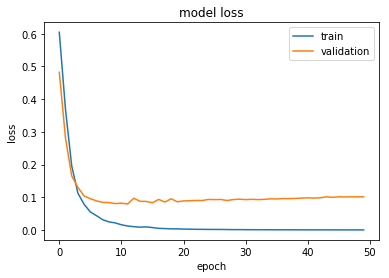

In [27]:
import matplotlib.pyplot as plt
history = model.fit(train_features, train_labels, epochs=50, verbose=0, validation_split=0.25)
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

### Plot the accuracy of our model

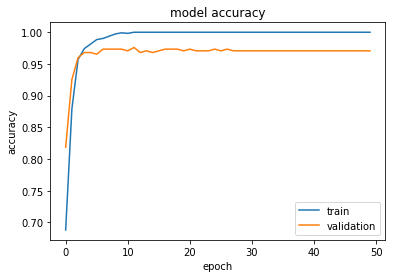

In [36]:
plt.figure()
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

### Generate a confusion matrix to examine the predictions

Confusion matrix:
 [[243   6]
 [ 10 240]]


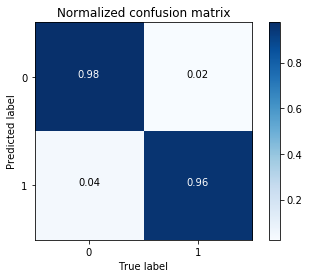

In [29]:
from sklearn.metrics import confusion_matrix
import itertools

predicted_labels = model.predict(np.stack(test_features))
cm = confusion_matrix(np.argmax(test_labels, axis=1), 
                      np.argmax(predicted_labels, axis=1))
                      
print('Confusion matrix:\n',cm)

cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Normalized confusion matrix')
plt.colorbar()

plt.xlabel('True label')
plt.ylabel('Predicted label')
plt.xticks([0, 1]); plt.yticks([0, 1])
plt.grid('off')
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], '.2f'),
             horizontalalignment='center',
             color='white' if cm[i, j] > 0.5 else 'black')

In [30]:
import tensorflow.keras.backend as K

def compute_salient_bases(model, x):
    input_tensors = [model.input]
    gradients = model.optimizer.get_gradients(model.output[0][1], model.input)
    compute_gradients = K.function(inputs = input_tensors, outputs = gradients)
    x_value = np.expand_dims(x, axis=0)
    gradients = compute_gradients([x_value])[0][0]
    sal = np.clip(np.sum(np.multiply(gradients,x), axis=1),a_min=0, a_max=None)
    return sal

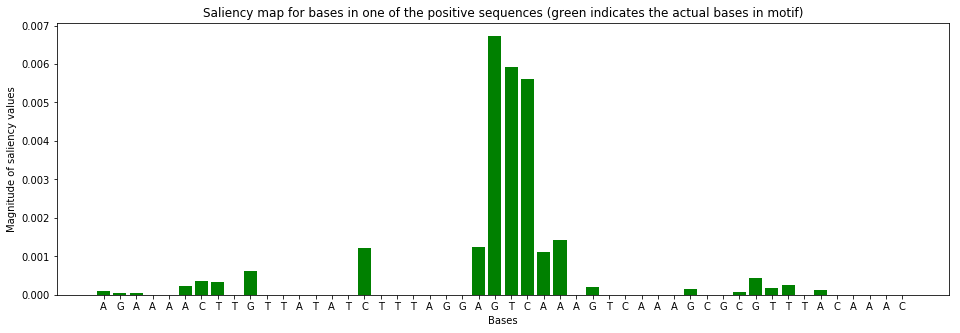

In [32]:
sequence_index = 1995
# You can change this to compute the gradient for a different example. But if so, change the coloring below as well.
sal = compute_salient_bases(model, input_features[sequence_index])

plt.figure(figsize=[16,5])
barlist = plt.bar(np.arange(len(sal)), sal, color='g')
plt.xlabel('Bases')
plt.ylabel('Magnitude of saliency values')
plt.xticks(np.arange(len(sal)), list(sequences[sequence_index]));
plt.title('Saliency map for bases in one of the positive sequences'
          ' (green indicates the actual bases in motif)');

#### The WRKY45 motif (from DAP-seq site) and it's reverse complement

![WRKY45 motif](http://neomorph.salk.edu/dap_web/pages/dap_data_v4/motifs/WRKY_tnt/WRKY45_col_a/meme_out/logo1.png) ![WRKY45 motif](http://neomorph.salk.edu/dap_web/pages/dap_data_v4/motifs/WRKY_tnt/WRKY45_col_a/meme_out/logo_rc1.png)

#### The WRKY18 motif (from DAP-seq site) and it's reverse complement


![WRKY45 motif](http://neomorph.salk.edu/dap_web/pages/dap_data_v4/motifs/WRKY_tnt/WRKY18_col_a/meme_out/logo_rc1.png) ![WRKY45 motif](http://neomorph.salk.edu/dap_web/pages/dap_data_v4/motifs/WRKY_tnt/WRKY18_col_a/meme_out/logo1.png)

#### The WRKY45 motifs (from [https://www.pnas.org/content/111/6/2367])
![WRKY45 motif](wrky_motifs.png)

In [ ]:
sequence_index = 400  # You can change this to compute the gradient for a different example. But if so, change the coloring below as well.
sal = compute_salient_bases(model, input_features[sequence_index])

plt.figure(figsize=[16,5])
barlist = plt.bar(np.arange(len(sal)), sal, color='r')
plt.xlabel('Bases')
plt.ylabel('Magnitude of saliency values')
plt.xticks(np.arange(len(sal)), list(sequences[sequence_index]));
plt.title('Saliency map for bases in one of the negative sequences'
          ' (green indicates the actual bases in motif)');

### What is in the model?

In [ ]:
model.output_shape

In [ ]:
from keras.utils import plot_model
plot_model(model, to_file='model.svg')

![model.svb](model.svg)

#### Looks like the model is just putting out either [1,0] or [0,1] for positive and negative labels, resp.

In [ ]:
model.get_weights()[1]

In [ ]:
model.get_weights()[1].shape

In [ ]:
print("there are " + str(len(model.get_weights()[1])) + " weights....")

#### Looks like we have a weight for each of the filters from the first Conv1D layer

In [ ]:
model.get_config()

In [ ]:
model.summary()

In [ ]:
x=input_features[1700]
x[:25]
x_value = np.expand_dims(x, axis=0)
x_value

In [ ]:
input_tensors = [model.input]
gradients = model.optimizer.get_gradients(model.output[0][1], model.input)
compute_gradients = K.function(inputs = input_tensors, outputs = gradients)
x=input_features[1650]
x_value = np.expand_dims(x, axisa0)
gradients = compute_gradients([x_value])[0][0]
gradients

In [ ]:
x[:5]

In [ ]:
np.clip(np.sum(np.multiply(gradients,x), axis=1),a_min=0, a_max=None)

In [ ]:
def compute_salient_bases(model, x):
    input_tensors = [model.input]
    gradients = model.optimizer.get_gradients(model.output[0][1], model.input)
    compute_gradients = K.function(inputs = input_tensors, outputs = gradients)
    x_value = np.expand_dims(x, axis=0)
    gradients = compute_gradients([x_value])[0][0]
    sal = np.clip(np.sum(np.multiply(gradients,x), axis=1),a_min=0, a_max=None)
    return sal